In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from  nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

In [4]:
sms_df = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='ISO-8859-1')
print(f'sms_df shape: {sms_df.shape}\n')
sms_df.head()

sms_df shape: (5572, 5)



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
sms_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
sms_df.isna().sum()

v1    0
v2    0
dtype: int64

In [6]:
sms_df.columns = ['label', 'message']

## Data Preprocessing

In [7]:
# convert all messages to lower case
sms_df['message'] = sms_df['message'].str.lower()
sms_df['message'][:2]

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
Name: message, dtype: object

In [8]:
sms_df.dtypes

label      object
message    object
dtype: object

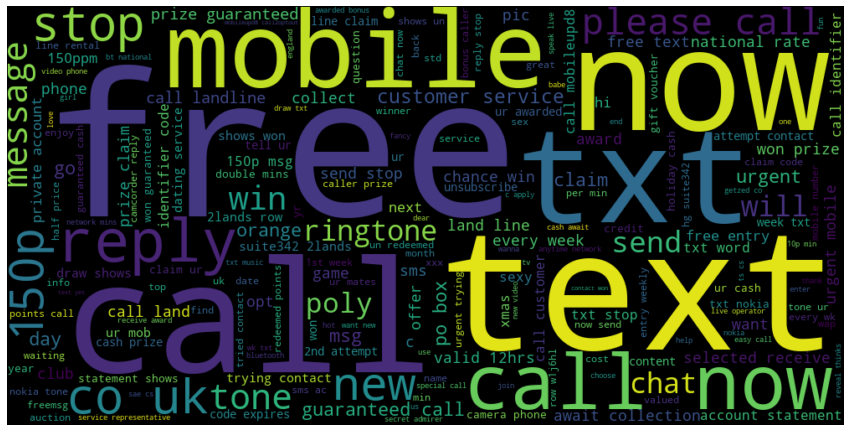

In [9]:
# apply word cloud to visualize the most used spam words
cloud_sms = WordCloud(width=1000, height=500).generate(' '.join(sms_df['message'][sms_df['label']=='spam']))

plt.figure(figsize=(15,8))
plt.imshow(cloud_sms, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
sms_df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

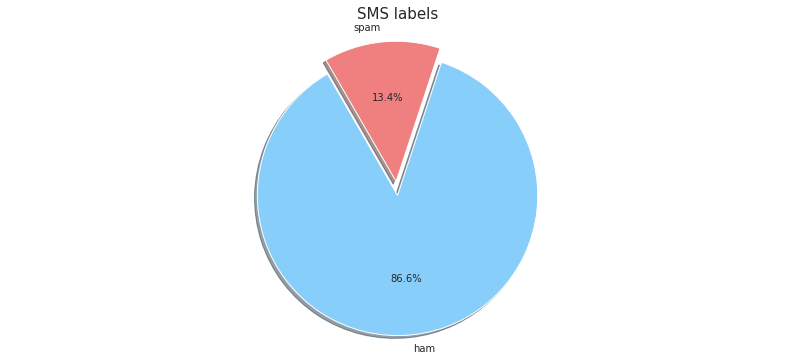

In [11]:
plt.figure(figsize=(14,6))
labels = ['ham', 'spam']
colors = ['lightskyblue', 'lightcoral']
explode = [0.1, 0]
plt.pie(x=sms_df.groupby('label').count()['message'], labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')
plt.title('SMS labels', size=15)
plt.show()

In [12]:
sms_df['length'] = sms_df['message'].apply(len)
sms_df.head()

,label,message,length
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61


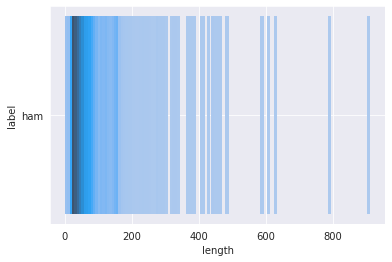

In [13]:
spam_df = sms_df[sms_df['label']=='spam']
ham_df = sms_df[sms_df['label']=='ham']

sns.histplot(x=ham_df['length'], y=ham_df['label'])

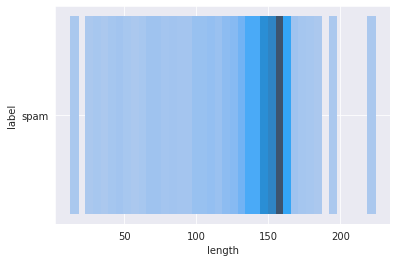

In [14]:
sns.histplot(x=spam_df['length'], y=spam_df['label'])

SMS spam messages are mostly longer in length, averaging 150 words, unlike ham which is having less than 100 words in each message.

### Data Preprocessing

In [15]:
# Replace email address with 'emailaddress'
sms_df['message'] = sms_df['message'].str.replace(r'^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$', 'emailaddress')

# Replace urls with 'webaddress'
sms_df['message'] = sms_df['message'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'webaddress')

# Replace money symbol with 'money-symbol'
sms_df['message'] = sms_df['message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
sms_df['message'] = sms_df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
sms_df['message'] = sms_df['message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
sms_df['message'] = sms_df['message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
sms_df['message'] = sms_df['message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
sms_df['message'] = sms_df['message'].str.replace(r'^\s+|\s*?$', ' ')


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Removing of stop words
stop_words = set(stopwords.words('english'))
sms_df['message'] = sms_df['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [18]:
# Using porterstemmer for the stemming
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
sms_df['message'] = sms_df['message'].apply(lambda x: ' '.join(ps.stem(word) for word in x.split()))

In [19]:
sms_df['label'] = sms_df['label'].map({'ham':1, 'spam':0})
sms_df.head()

,label,message,length
0,1,go jurong point crazi avail bugi n great world...,111
1,1,ok lar joke wif u oni,29
2,0,free entri number wkli comp win fa cup final t...,155
3,1,u dun say earli hor u c alreadi say,49
4,1,nah think goe usf live around though,61


In [20]:
feature = sms_df['message']
label = sms_df['label']
X_train, X_test, y_train, y_test = train_test_split(feature, label, 
                                                    test_size=0.3, random_state=42)

## Vectorization

They are a form of data preprocessing, that word tokenizes sentences, and maps vectors to each word. 

The CountVectorizer and Tfidf Vectorizer will be tested. The one that produces the best result will be proceeded with.

In [21]:
# CountVectorizer
count_vectorizer = CountVectorizer()

count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

print(count_vectorizer.get_feature_names()[:10])

['____', 'aa', 'aah', 'aaooooright', 'aathi', 'ab', 'abbey', 'abeg', 'abel', 'aberdeen']


In [22]:
count_vectorizer.vocabulary_

{'review': 3906,
 'keep': 2423,
 'fantast': 1564,
 'nokia': 3090,
 'gage': 1778,
 'game': 1784,
 'deck': 1119,
 'club': 855,
 'go': 1853,
 'number': 3135,
 'www': 5325,
 'cnupdat': 870,
 'com': 894,
 'newslett': 3056,
 'unsubscrib': 4976,
 'alert': 122,
 'repli': 3871,
 'word': 5283,
 'got': 1888,
 'outta': 3385,
 'class': 835,
 'gonna': 1868,
 'gym': 1950,
 'come': 897,
 'friday': 1735,
 'leav': 2520,
 'pongal': 3587,
 'get': 1821,
 'news': 3055,
 'work': 5284,
 'place': 3533,
 'hi': 2045,
 'dear': 1107,
 'call': 663,
 'urgnt': 4997,
 'know': 2455,
 'what': 5196,
 'problem': 3675,
 'want': 5122,
 'least': 2518,
 'tell': 4656,
 'wate': 5135,
 'friend': 1737,
 'say': 4023,
 'up': 4979,
 'order': 3357,
 'gram': 1902,
 'money': 2906,
 'symbol': 4578,
 'lt': 2654,
 'gt': 1934,
 'telli': 4657,
 'brdget': 568,
 'jone': 2372,
 'ye': 5362,
 'saw': 4022,
 'messag': 2812,
 'new': 3051,
 'voicemail': 5085,
 'pleas': 3546,
 'yesterday': 5375,
 'true': 4878,
 'think': 4721,
 'made': 2691,
 'day': 1

In [23]:
# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_train.A[:5])

['____', 'aa', 'aah', 'aaooooright', 'aathi', 'ab', 'abbey', 'abeg', 'abel', 'aberdeen']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

print(count_df.head())
print(tfidf_df.head())
print(count_df.equals(tfidf_df))

   ____  aa  aah  aaooooright  aathi  ab  ...  ûªt  ûªve  ûï  ûïharri  ûò  ûówell
0     0   0    0            0      0   0  ...    0     0   0        0   0       0
1     0   0    0            0      0   0  ...    0     0   0        0   0       0
2     0   0    0            0      0   0  ...    0     0   0        0   0       0
3     0   0    0            0      0   0  ...    0     0   0        0   0       0
4     0   0    0            0      0   0  ...    0     0   0        0   0       0

[5 rows x 5435 columns]
   ____   aa  aah  aaooooright  aathi  ...  ûªve   ûï  ûïharri   ûò  ûówell
0   0.0  0.0  0.0          0.0    0.0  ...   0.0  0.0      0.0  0.0     0.0
1   0.0  0.0  0.0          0.0    0.0  ...   0.0  0.0      0.0  0.0     0.0
2   0.0  0.0  0.0          0.0    0.0  ...   0.0  0.0      0.0  0.0     0.0
3   0.0  0.0  0.0          0.0    0.0  ...   0.0  0.0      0.0  0.0     0.0
4   0.0  0.0  0.0          0.0    0.0  ...   0.0  0.0      0.0  0.0     0.0

[5 rows x 5435 columns]
Fa

**Predicting with count vectorizer training set**

In [25]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

# THIS PRODUCED THE BEST MODEL
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
nb_prediction = nb_classifier.predict(count_test)
print(classification_report(y_test, nb_prediction))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       219
           1       0.99      0.99      0.99      1453

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.97      1672
weighted avg       0.98      0.98      0.98      1672



In [26]:
from sklearn.metrics import f1_score, precision_score
print(f'f1-score = {f1_score(y_test, nb_prediction)}')

f1-score = 0.9910591471801926


In [27]:
print(f'precision score = {precision_score(y_test, nb_prediction)}')

precision score = 0.9903780068728523


In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, nb_prediction)
print(cm)

[[ 205   14]
 [  12 1441]]


**Predicting with tfidf training set**




In [29]:
nb_classifier2 = MultinomialNB()
nb_classifier2.fit(tfidf_train, y_train)
nb_prediction2 = nb_classifier2.predict(tfidf_test)
print(classification_report(y_test, nb_prediction2))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       219
           1       0.97      1.00      0.98      1453

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



In [30]:
print(f'f1-score = {f1_score(y_test, nb_prediction2)}')

f1-score = 0.9827411167512691


In [31]:
cm2 = confusion_matrix(y_test, nb_prediction2)
print(cm2)

[[ 169   50]
 [   1 1452]]


Comparing the evaluation metrics in the classification report especially for the smaller and important class, count Vectorizer produced a better prediction than Tfidf Vectorizer. 

In [32]:
from sklearn.svm import SVC
svc_classifier = SVC()
svc_classifier.fit(count_train, y_train)
svc_prediction = svc_classifier.predict(count_test)
print(classification_report(y_test, svc_prediction))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       219
           1       0.98      1.00      0.99      1453

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [33]:
svc_cm = confusion_matrix(y_test, svc_prediction)
print(svc_cm)

[[ 195   24]
 [   2 1451]]


In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(count_train, y_train)
knn_prediction = knn_classifier.predict(count_test)
print(classification_report(y_test, knn_prediction))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       219
           1       0.97      0.99      0.98      1453

    accuracy                           0.97      1672
   macro avg       0.96      0.91      0.93      1672
weighted avg       0.97      0.97      0.97      1672



In [35]:
knn_cm = confusion_matrix(y_test, knn_prediction)
print(knn_cm)

[[ 179   40]
 [  10 1443]]


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [37]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, nb_prediction, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, svc_prediction, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, knn_prediction, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

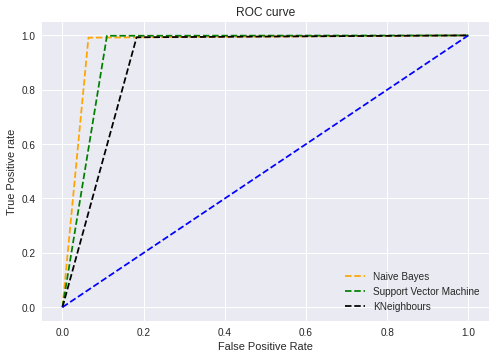

In [38]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Naive Bayes')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Support Vector Machine')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='KNeighbours')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

Naive Bayes had the best performance.

In [39]:
# Save the nb_classifier
import pickle
f = open('nb_classifier.pickle', 'wb')
pickle.dump(nb_classifier, f)
f.close()

In [40]:
# # To load model:
# import pickle
# f = open('nb_classifier.pickle', 'rb')
# classifier = pickle.load(f)
# f.close()

# # To retrain classifier:
# f = open('nb_classifier.pickle','rb')
# classifier = pickle.load(f)
# classifier.train(training_set)
# print('Accuracy:',nltk.classify.accuracy(classifier,testing_set)*100)
# f.close()